# Imports

In [1]:
# layer_utils imports
import os

import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import (
    Activation,
    Add,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    InputSpec,
    Lambda,
    Layer,
    LeakyReLU,
    UpSampling2D,
)
from keras.models import Model
from PIL import Image
from tensorflow.python.keras.utils import conv_utils

# layer_utils.py

In [2]:
def res_block(input, filters, kernel_size=(3, 3), strides=(1, 1), use_dropout=False):
    """
    Instanciate a Keras Resnet Block using sequential API.

    :param input: Input tensor
    :param filters: Number of filters to use
    :param kernel_size: Shape of the kernel for the convolution
    :param strides: Shape of the strides for the convolution
    :param use_dropout: Boolean value to determine the use of dropout
    :return: Keras Model
    """
    x = ReflectionPadding2D((1, 1))(input)
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if use_dropout:
        x = Dropout(0.5)(x)

    x = ReflectionPadding2D((1, 1))(x)
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
    )(x)
    x = BatchNormalization()(x)

    merged = Add()([input, x])
    return merged

In [3]:
def spatial_reflection_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None):
    """
    Pad the 2nd and 3rd dimensions of a 4D tensor.

    :param x: Input tensor
    :param padding: Shape of padding to use
    :param data_format: Tensorflow vs Theano convention ('channels_last', 'channels_first')
    :return: Tensorflow tensor
    """
    assert len(padding) == 2
    assert len(padding[0]) == 2
    assert len(padding[1]) == 2
    if data_format is None:
        data_format = image_data_format()
    if data_format not in {"channels_first", "channels_last"}:
        raise ValueError("Unknown data_format " + str(data_format))

    if data_format == "channels_first":
        pattern = [[0, 0], [0, 0], list(padding[0]), list(padding[1])]
    else:
        pattern = [[0, 0], list(padding[0]), list(padding[1]), [0, 0]]
    return tf.pad(x, pattern, "REFLECT")

In [4]:
class ReflectionPadding2D(Layer):
    """Reflection-padding layer for 2D input (e.g. picture).
    This layer can add rows and columns or zeros
    at the top, bottom, left and right side of an image tensor.
    # Arguments
        padding: int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
            - If int: the same symmetric padding
                is applied to width and height.
            - If tuple of 2 ints:
                interpreted as two different
                symmetric padding values for height and width:
                `(symmetric_height_pad, symmetric_width_pad)`.
            - If tuple of 2 tuples of 2 ints:
                interpreted as
                `((top_pad, bottom_pad), (left_pad, right_pad))`
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, rows, cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, rows, cols)`
    # Output shape
        4D tensor with shape:
        - If `data_format` is `"channels_last"`:
            `(batch, padded_rows, padded_cols, channels)`
        - If `data_format` is `"channels_first"`:
            `(batch, channels, padded_rows, padded_cols)`
    """

    def __init__(self, padding=(1, 1), data_format=None, **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        if isinstance(padding, int):
            self.padding = ((padding, padding), (padding, padding))
        elif hasattr(padding, "__len__"):
            if len(padding) != 2:
                raise ValueError(
                    "`padding` should have two elements. " "Found: " + str(padding)
                )
            height_padding = conv_utils.normalize_tuple(
                padding[0], 2, "1st entry of padding"
            )
            width_padding = conv_utils.normalize_tuple(
                padding[1], 2, "2nd entry of padding"
            )
            self.padding = (height_padding, width_padding)
        else:
            raise ValueError(
                "`padding` should be either an int, "
                "a tuple of 2 ints "
                "(symmetric_height_pad, symmetric_width_pad), "
                "or a tuple of 2 tuples of 2 ints "
                "((top_pad, bottom_pad), (left_pad, right_pad)). "
                "Found: " + str(padding)
            )
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == "channels_first":
            if input_shape[2] is not None:
                rows = input_shape[2] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[3] is not None:
                cols = input_shape[3] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], input_shape[1], rows, cols)
        elif self.data_format == "channels_last":
            if input_shape[1] is not None:
                rows = input_shape[1] + self.padding[0][0] + self.padding[0][1]
            else:
                rows = None
            if input_shape[2] is not None:
                cols = input_shape[2] + self.padding[1][0] + self.padding[1][1]
            else:
                cols = None
            return (input_shape[0], rows, cols, input_shape[3])

    def call(self, inputs):
        return spatial_reflection_2d_padding(
            inputs, padding=self.padding, data_format=self.data_format
        )

    def get_config(self):
        config = {"padding": self.padding, "data_format": self.data_format}
        base_config = super(ReflectionPadding2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
input = Input(shape=(256, 256, 3))
x = ReflectionPadding2D(3)(input)
model = Model(input, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 reflection_padding2d (Refle  (None, 262, 262, 3)      0         
 ctionPadding2D)                                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# losses.py

In [6]:
# Note: The image shape must be multiple of patch_shape
image_shape = (256, 256, 3)

In [7]:
def l1_loss(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

In [8]:
def perceptual_loss_100(y_true, y_pred):
    return 100 * perceptual_loss(y_true, y_pred)

In [35]:
image_shape = (256, 256, 3)  # Replace with your actual image shape
vgg = VGG16(include_top=False, weights="imagenet", input_shape=image_shape)
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
loss_model.trainable = False  # Freeze the VGG16 layers

In [36]:
def perceptual_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(loss_model(y_true) - loss_model(y_pred)))

In [10]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [11]:
def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(
        gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))
    )

    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)

    return tf.reduce_mean(gradient_penalty)

# model.py

In [12]:
# the paper defined hyper-parameter:chr
channel_rate = 64
# Note the image_shape must be multiple of patch_shape
image_shape = (256, 256, 3)
patch_shape = (channel_rate, channel_rate, 3)

ngf = 64
ndf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
input_shape_discriminator = (256, 256, output_nc)
n_blocks_gen = 9

In [13]:
def generator_model():
    """Build generator architecture."""
    # Current version : ResNet block
    inputs = Input(shape=image_shape)

    x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding="valid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(
            filters=ngf * mult * 2, kernel_size=(3, 3), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf * mult, use_dropout=True)

    for i in range(n_downsampling):
        mult = 2 ** (n_downsampling - i)
        # x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding='same')(x)
        x = UpSampling2D()(x)
        x = Conv2D(filters=int(ngf * mult / 2), kernel_size=(3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7, 7), padding="valid")(x)
    x = Activation("tanh")(x)

    outputs = Add()([x, inputs])
    # outputs = Lambda(lambda z: K.clip(z, -1, 1))(x)
    outputs = Lambda(lambda z: z / 2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="Generator")
    return model

In [14]:
def discriminator_model():
    """Build discriminator architecture."""
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(
            filters=ndf * nf_mult, kernel_size=(4, 4), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf * nf_mult, kernel_size=(4, 4), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding="same")(x)
    if use_sigmoid:
        x = Activation("sigmoid")(x)

    x = Flatten()(x)
    x = Dense(1024, activation="tanh")(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

In [15]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model

## Generator and Discriminator Models summary/layout

In [17]:
g = generator_model()
g.summary()
d = discriminator_model()
d.summary()
m = generator_containing_discriminator(generator_model(), discriminator_model())
m.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d_1 (Reflec  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 tionPadding2D)                                                                                   
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['reflection_padding2d_1[0][0]'] 
                                )                                                         

# utils.py

In [18]:
RESHAPE = (256, 256)

In [19]:
def is_an_image_file(filename):
    IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

In [20]:
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

In [21]:
def load_image(path):
    img = Image.open(path)
    return img

In [22]:
def preprocess_image(cv_img):
    cv_img = cv_img.resize(RESHAPE)
    img = np.array(cv_img)
    img = (img - 127.5) / 127.5
    return img

In [23]:
def deprocess_image(img):
    img = img * 127.5 + 127.5
    return img.astype("uint8")

In [24]:
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)

In [25]:
def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    A_paths, B_paths = os.path.join(path, "A"), os.path.join(path, "B")
    all_A_paths, all_B_paths = list_image_files(A_paths), list_image_files(B_paths)
    images_A, images_B = [], []
    images_A_paths, images_B_paths = [], []
    for path_A, path_B in zip(all_A_paths, all_B_paths):
        img_A, img_B = load_image(path_A), load_image(path_B)
        images_A.append(preprocess_image(img_A))
        images_B.append(preprocess_image(img_B))
        images_A_paths.append(path_A)
        images_B_paths.append(path_B)
        if len(images_A) > n_images - 1:
            break

    return {
        "A": np.array(images_A),
        "A_paths": np.array(images_A_paths),
        "B": np.array(images_B),
        "B_paths": np.array(images_B_paths),
    }

In [26]:
def write_log(callback, names, logs, batch_no):
    """
    Util to write callback for Keras training
    """
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

# train.py

In [28]:
import datetime

import click
import tqdm
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

# from deblurgan.utils import load_images, write_log
# from deblurgan.losses import wasserstein_loss, perceptual_loss
# from deblurgan.model import generator_model, discriminator_model, generator_containing_discriminator_multiple_outputs

In [29]:
BASE_DIR = "weights/"

In [30]:
def save_all_weights(d, g, epoch_number, current_loss):
    now = datetime.datetime.now()
    save_dir = os.path.join(BASE_DIR, "{}{}".format(now.month, now.day))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save_weights(
        os.path.join(save_dir, "generator_{}_{}.h5".format(epoch_number, current_loss)),
        True,
    )
    d.save_weights(
        os.path.join(save_dir, "discriminator_{}.h5".format(epoch_number)), True
    )

In [31]:
def train_multiple_outputs(n_images, batch_size, log_dir, epoch_num, critic_updates=5):
    data = load_images("./images/train", n_images)
    y_train, x_train = data["B"], data["A"]

    g = generator_model()
    d = discriminator_model()
    d_on_g = generator_containing_discriminator_multiple_outputs(g, d)

    d_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    d_on_g_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    d.trainable = True
    d.compile(optimizer=d_opt, loss=wasserstein_loss)
    d.trainable = False
    loss = [perceptual_loss, wasserstein_loss]
    loss_weights = [100, 1]
    d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
    d.trainable = True

    output_true_batch, output_false_batch = np.ones((batch_size, 1)), -np.ones(
        (batch_size, 1)
    )

    log_path = "./logs"
    tensorboard_callback = TensorBoard(log_path)

    for epoch in tqdm.tqdm(range(epoch_num)):
        permutated_indexes = np.random.permutation(x_train.shape[0])

        d_losses = []
        d_on_g_losses = []
        for index in range(int(x_train.shape[0] / batch_size)):
            batch_indexes = permutated_indexes[
                index * batch_size : (index + 1) * batch_size
            ]
            image_blur_batch = x_train[batch_indexes]
            image_full_batch = y_train[batch_indexes]

            generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

            for _ in range(critic_updates):
                d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
                d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                d_losses.append(d_loss)

            d.trainable = False

            d_on_g_loss = d_on_g.train_on_batch(
                image_blur_batch, [image_full_batch, output_true_batch]
            )
            d_on_g_losses.append(d_on_g_loss)

            d.trainable = True

        # write_log(tensorboard_callback, ['g_loss', 'd_on_g_loss'], [np.mean(d_losses), np.mean(d_on_g_losses)], epoch_num)
        print(np.mean(d_losses), np.mean(d_on_g_losses))
        with open("log.txt", "a+") as f:
            f.write(
                "{} - {} - {}\n".format(
                    epoch, np.mean(d_losses), np.mean(d_on_g_losses)
                )
            )

        save_all_weights(d, g, epoch, int(np.mean(d_on_g_losses)))

In [32]:
def train_command(n_images, batch_size, log_dir, epoch_num, critic_updates):
    return train_multiple_outputs(
        n_images, batch_size, log_dir, epoch_num, critic_updates
    )

## training parameters (change them as needed)

In [33]:
n_images = 512  # Number of images to load for training
batch_size = 16  # Size of batch
log_dir = True  # Path to the log_dir for Tensorboard
epoch_num = 4  # Number of epochs for training
critic_updates = 5  # Number of discriminator training

In [37]:
train_command(
    n_images=n_images,
    batch_size=batch_size,
    log_dir=log_dir,
    epoch_num=epoch_num,
    critic_updates=critic_updates,
)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


 25%|████████████████████▊                                                              | 1/4 [01:52<05:36, 112.33s/it]

-0.4155534088014292 1698.7127706460888
1/1 [==============================] - 0s 18ms/step


 50%|██████████████████████████████████████████                                          | 2/4 [03:13<03:08, 94.15s/it]

-0.21481430181332256 1221.3877880521857
1/1 [==============================] - 0s 16ms/step


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:34<01:28, 88.22s/it]

-0.41879146142375473 1103.1363534039508
1/1 [==============================] - 0s 17ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:56<00:00, 89.02s/it]

-0.4992337052131498 1037.963168485711


# test.py

In [43]:
def test(batch_size):
    data = load_images("./images/test", batch_size)
    y_test, x_test = data["B"], data["A"]
    g = generator_model()
    g.load_weights("./weights/94/generator_3_1037.h5")
    generated_images = g.predict(x=x_test, batch_size=batch_size)
    generated = np.array([deprocess_image(img) for img in generated_images])
    x_test = deprocess_image(x_test)
    y_test = deprocess_image(y_test)

    for i in range(generated_images.shape[0]):
        y = y_test[i, :, :, :]
        x = x_test[i, :, :, :]
        img = generated[i, :, :, :]
        output = np.concatenate((y, x, img), axis=1)
        im = Image.fromarray(output.astype(np.uint8))
        im.save("results{}.png".format(i))

In [44]:
batch_size = 4  # Number of images to process

In [45]:
test(batch_size=batch_size)

1/1 [==============================] - 1s 844ms/step


# Results

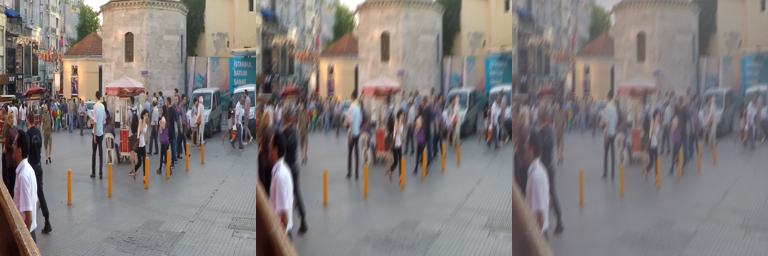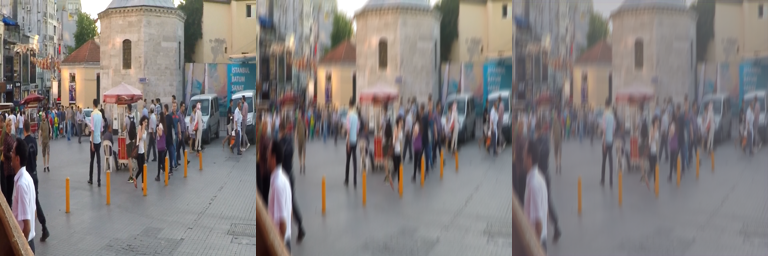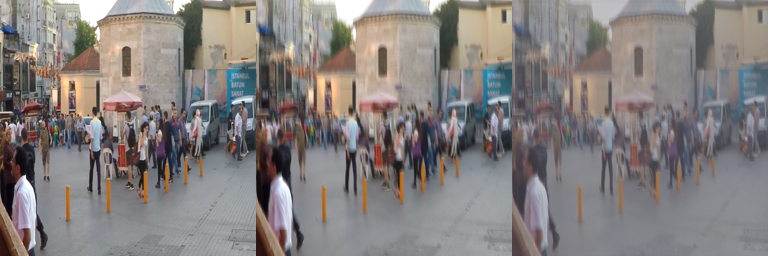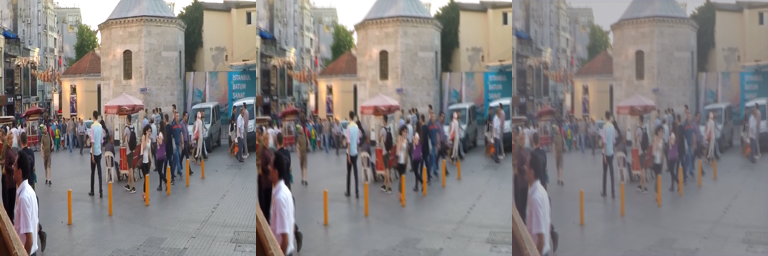